In [21]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import datetime

# ============================ #
# 🧩 Dataset: NMF on Mel Spec  #
# ============================ #

In [24]:
class NMFHybridDataset(Dataset):
    def __init__(self, bio_dir, nonbio_dir, n_components=10):
        self.samples = []
        self.n_components = n_components
        
        # 🐳 Biological
        for file in os.listdir(bio_dir):
            if file.endswith('.npy'):
                self.samples.append((os.path.join(bio_dir, file), 1))
        
        # ⚓ Non-biological
        for file in os.listdir(nonbio_dir):
            if file.endswith('.npy'):
                self.samples.append((os.path.join(nonbio_dir, file), 0))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        mel = np.load(path)
        
        # 🌊 Min-max normalization to ensure non-negativity
        mel_min = mel.min()
        mel_max = mel.max()
        mel = (mel - mel_min) / (mel_max - mel_min + 1e-6)  # Ensures values between 0-1
        
        # 🎛️ Apply NMF
        model = NMF(n_components=self.n_components, init='random', max_iter=500, tol=0.001, random_state=0)
        H = model.fit_transform(mel.T).T  # shape: (components, time)
        
        # 🎯 Mean over time to get feature vector
        features = np.mean(H, axis=1)  # shape: (components,)
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# ============================ #
# 🤖 Classifier Model (MLP)   #
# ============================ #

In [26]:
class NMFClassifier(nn.Module):
    def __init__(self, n_components=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_components, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Binary output 🐳⚓
        )

    def forward(self, x):
        return self.net(x)


# ============================ #
# 🏋️ Training + Evaluation    #
# ============================ #

In [28]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            out = model(X)
            preds = out.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm

# ============================ #
# 📊 Plot Functions           #
# ============================ #

In [30]:
def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Bio", "Bio"]) 
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()

def plot_accuracy_curves(train_accs, val_accs):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label="Train", marker='o') 
    plt.plot(val_accs, label="Validation", marker='x') 
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_curves.png")
    plt.show()

# ============================ #
# 🚀 MAIN FUNCTION             #
# ============================ #

🚀 Starting training with 30 NMF components
📂 Loading data from D:\SDP\Pre Processed\1\Biological\Mel Spectogram and D:\SDP\Pre Processed\1\Non Biological\Mel Spectogram
📊 Dataset size: 2072 samples
🔀 Splits: Train=1450, Val=310, Test=312
🖥️ Using device: cpu
🏋️ Starting training...
Epoch 1/20 🏁 | Train Loss: 5.7354 | Train Acc: 0.6917 | Val Acc: 0.7516
💾 New best model saved! (Val Acc: 0.7516)
Epoch 2/20 🏁 | Train Loss: 3.3241 | Train Acc: 0.6972 | Val Acc: 0.7516
Epoch 3/20 🏁 | Train Loss: 2.9706 | Train Acc: 0.7586 | Val Acc: 0.8581
💾 New best model saved! (Val Acc: 0.8581)
Epoch 4/20 🏁 | Train Loss: 2.6547 | Train Acc: 0.8938 | Val Acc: 0.9290
💾 New best model saved! (Val Acc: 0.9290)
Epoch 5/20 🏁 | Train Loss: 2.0863 | Train Acc: 0.9207 | Val Acc: 0.9484
💾 New best model saved! (Val Acc: 0.9484)
Epoch 6/20 🏁 | Train Loss: 1.6924 | Train Acc: 0.9255 | Val Acc: 0.9452
Epoch 7/20 🏁 | Train Loss: 0.8112 | Train Acc: 0.9200 | Val Acc: 0.9516
💾 New best model saved! (Val Acc: 0.9516)
Epo

C:\Users\shiva\AppData\Local\Temp\ipykernel_19920\1357819465.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_best_model_path))



✅ Final Test Accuracy: 0.9487 (94%)


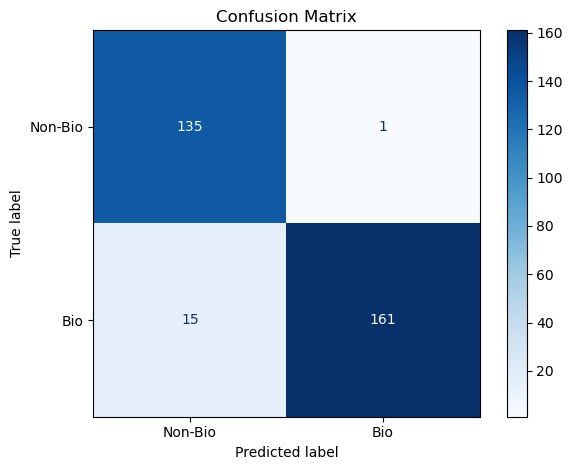

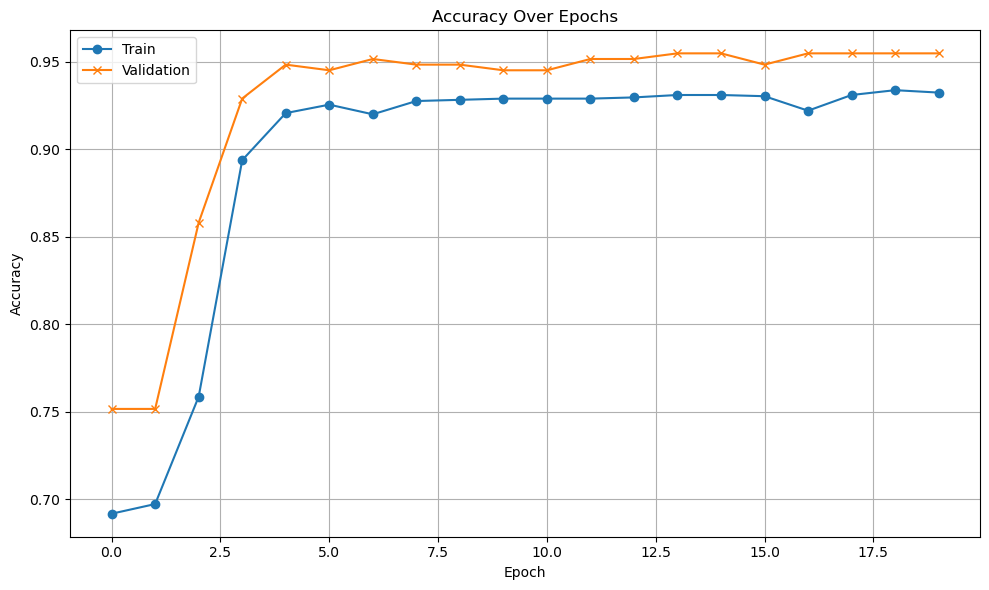

✅ Final model saved to: D:\SDP\Temp Models\nmf_classifier_final_acc94_20250421_102754.pth


In [32]:
def main():
    # Set paths to your data
    bio_path = r"D:\SDP\Pre Processed\1\Biological\Mel Spectogram"
    nonbio_path = r"D:\SDP\Pre Processed\1\Non Biological\Mel Spectogram"
    save_dir = r"D:\SDP\Temp Models"
    os.makedirs(save_dir, exist_ok=True)
    
    # Add timestamp for filenames
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Hyperparameters
    n_components = 30
    batch_size = 32
    learning_rate = 1e-3
    epochs = 20  # Increased from 10
    
    print(f"🚀 Starting training with {n_components} NMF components")
    print(f"📂 Loading data from {bio_path} and {nonbio_path}")
    # Create dataset
    dataset = NMFHybridDataset(bio_path, nonbio_path, n_components=n_components)
    print(f"📊 Dataset size: {len(dataset)} samples")
    
    # Split dataset 📦
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_set, val_set, test_set = random_split(
        dataset, [train_size, val_size, test_size], 
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )
    print(f"🔀 Splits: Train={len(train_set)}, Val={len(val_set)}, Test={len(test_set)}")
    
    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    # Setup 🛠️
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️ Using device: {device}")
    
    model = NMFClassifier(n_components=n_components).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    # Training loop 🔁
    train_accs, val_accs = [], []
    best_val_acc = 0
    
    print("🏋️ Starting training...")
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_acc, _ = evaluate(model, val_loader, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} 🏁 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        # Save best model with val accuracy and timestamp
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            val_acc_percent = int(val_acc * 100)
            best_model_path = os.path.join(save_dir, f"nmf_classifier_best_acc{val_acc_percent}_{timestamp}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"💾 New best model saved! (Val Acc: {val_acc:.4f})")
    
    # Load the best model for final evaluation
    latest_best_model_path = os.path.join(save_dir, f"nmf_classifier_best_acc{int(best_val_acc * 100)}_{timestamp}.pth")
    model.load_state_dict(torch.load(latest_best_model_path))
    
    # Final Evaluation 📊
    test_acc, cm = evaluate(model, test_loader, device)
    acc_percent = int(test_acc * 100)
    print(f"\n✅ Final Test Accuracy: {test_acc:.4f} ({acc_percent}%)")
    # Plot confusion matrix
    plot_confusion_matrix(cm)
    
    # Accuracy Plot 📈
    plot_accuracy_curves(train_accs, val_accs)
    # 💾 Save final model with accuracy in filename and timestamp
    final_model_path = os.path.join(save_dir, f"nmf_classifier_final_acc{acc_percent}_{timestamp}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"✅ Final model saved to: {final_model_path}")

if __name__ == "__main__":
    main()